In [1]:
!tar -xvf ./data/cifar/cifar-10-python.tar.gz -C ./data/cifar/

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [2]:
import os
import pickle 
import paddle
import numpy as np

def load_cifar10_batch(folder_path, batch_id=1, mode='train'):
    if mode=='test':
        file_path=os.path.join(folder_path, 'test_batch')
    else:
        file_path=os.path.join(folder_path, 'data_batch_{}'.format(batch_id))
    with open(file_path, 'rb') as batch_file:
        batch = pickle.load(batch_file, encoding='latin1')
    imgs = batch['data'].reshape((len(batch['data']), 3, 32, 32)) / 255.
    labels = batch['labels']
    return np.array(imgs, dtype='float32'), np.array(labels)

In [3]:
imgs_batch, labels_batch = load_cifar10_batch(folder_path='./data/cifar/cifar-10-batches-py', batch_id=1, mode='train')

In [4]:
print ("batch of imgs shape: ",imgs_batch.shape, "batch of labels shape: ", labels_batch.shape)

batch of imgs shape:  (10000, 3, 32, 32) batch of labels shape:  (10000,)


The label in the picture is 9


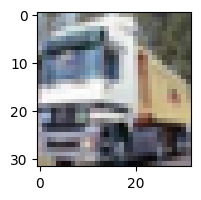

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

image, label = imgs_batch[1], labels_batch[1]
print("The label in the picture is {}".format(label))
plt.figure(figsize=(2, 2))
plt.imshow(image.transpose(1,2,0))

In [6]:
import paddle
import paddle.io as io
from paddle.vision.transforms import Normalize

class CIFAR10Dataset(io.Dataset):
    def __init__(self, folder_path='./data/cifar/cifar-10-batches-py', mode='train'):
        if mode == 'train':
            #加载batch1-batch4作为训练集
            self.imgs, self.labels = load_cifar10_batch(folder_path=folder_path, batch_id=1, mode='train')
            for i in range(2, 5):
                imgs_batch, labels_batch = load_cifar10_batch(folder_path=folder_path, batch_id=i, mode='train')
                self.imgs, self.labels = np.concatenate([self.imgs, imgs_batch]), np.concatenate([self.labels, labels_batch])
        elif mode == 'dev':
            #加载batch5作为验证集
            self.imgs, self.labels = load_cifar10_batch(folder_path=folder_path, batch_id=5, mode='dev')
        elif mode == 'test':
            #加载测试集
            self.imgs, self.labels = load_cifar10_batch(folder_path=folder_path, mode='test')
        self.transform = Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010], data_format='CHW')

    def __getitem__(self, idx):
        img, label = self.imgs[idx], self.labels[idx]
        img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.imgs)

paddle.seed(100)
train_dataset = CIFAR10Dataset(folder_path='./data/cifar/cifar-10-batches-py', mode='train')
dev_dataset = CIFAR10Dataset(folder_path='./data/cifar/cifar-10-batches-py', mode='dev')
test_dataset = CIFAR10Dataset(folder_path='./data/cifar/cifar-10-batches-py', mode='test')

In [7]:
from paddle.vision.models import resnet18
resnet18_model = resnet18()

W0616 02:05:29.855024 59595 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 12.0, Runtime API Version: 11.8
W0616 02:05:29.856367 59595 gpu_resources.cc:164] device: 0, cuDNN Version: 8.9.


In [8]:
import paddle.nn.functional as F
import paddle.optimizer as opt
from nndl import RunnerV3, Accuracy

#指定运行设备
use_gpu = True if paddle.get_device().startswith("gpu") else False
if use_gpu:
    paddle.set_device('gpu:0')
#学习率大小
lr = 0.001  
#批次大小
batch_size = 64 
#加载数据
train_loader = io.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = io.DataLoader(dev_dataset, batch_size=batch_size)
test_loader = io.DataLoader(test_dataset, batch_size=batch_size) 
#定义网络
model = resnet18_model
#定义优化器，这里使用Adam优化器以及l2正则化策略，相关内容在7.3.3.2和7.6.2中会进行详细介绍
optimizer = opt.Adam(learning_rate=lr, parameters=model.parameters(), weight_decay=0.005)
#定义损失函数
loss_fn = F.cross_entropy
#定义评价指标
metric = Accuracy(is_logist=True)
#实例化RunnerV3
runner = RunnerV3(model, optimizer, loss_fn, metric)
#启动训练
log_steps = 3000
eval_steps = 3000
runner.train(train_loader, dev_loader, num_epochs=30, log_steps=log_steps, 
                eval_steps=eval_steps, save_path="best_model.pdparams")

/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/paddle/nn/layer/norm.py:824: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


[Train] epoch: 0/30, step: 0/18750, loss: 7.92117
[Evaluate]  dev_score: 0.00000, dev_loss: 16.08030
[Train] epoch: 4/30, step: 3000/18750, loss: 1.19056
[Evaluate]  dev_score: 0.65870, dev_loss: 0.99827
best accuracy performence has been updated: 0.00000 --> 0.65870
[Train] epoch: 9/30, step: 6000/18750, loss: 1.03660
[Evaluate]  dev_score: 0.71970, dev_loss: 0.83236
best accuracy performence has been updated: 0.65870 --> 0.71970
[Train] epoch: 14/30, step: 9000/18750, loss: 0.58432
[Evaluate]  dev_score: 0.71750, dev_loss: 0.84510
[Train] epoch: 19/30, step: 12000/18750, loss: 0.55952
[Evaluate]  dev_score: 0.73200, dev_loss: 0.82651
best accuracy performence has been updated: 0.71970 --> 0.73200
[Train] epoch: 24/30, step: 15000/18750, loss: 0.64313
[Evaluate]  dev_score: 0.73860, dev_loss: 0.77516
best accuracy performence has been updated: 0.73200 --> 0.73860
[Train] epoch: 28/30, step: 18000/18750, loss: 0.64262
[Evaluate]  dev_score: 0.73690, dev_loss: 0.79965
[Train] Training d

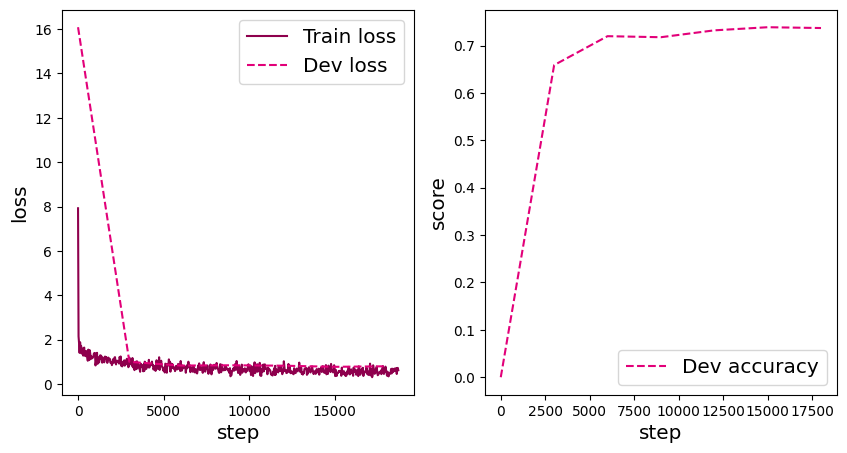

In [9]:
from nndl import plot

plot(runner, fig_name='cnn-loss4.pdf')

In [26]:
# 加载最优模型
runner.load_model('best_model.pdparams')
# 模型评价
score, loss = runner.evaluate(test_loader)
print("[Test] accuracy/loss: {:.4f}/{:.4f}".format(score, loss))

[Test] accuracy/loss: 0.7346/0.8096


The actual category is automobile and the predicted category is automobile


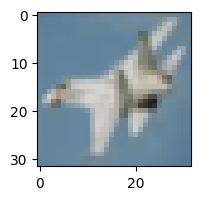

In [28]:
id2label = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
X, label_ids = next(test_loader())
logits = runner.predict(X)
pred_class_id = paddle.argmax(logits[9]).numpy()
label_id = label_ids[9].numpy()
pred_class = id2label[pred_class_id.item()]
label = id2label[label_id.item()]
print("The actual category is {} and the predicted category is {}".format(label, pred_class))
plt.figure(figsize=(2,2))
imgs, labels = load_cifar10_batch(folder_path='./data/cifar/cifar-10-batches-py', mode='test')
plt.imshow(imgs[10].transpose(1,2,0))